In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/Team-AY/FER-NN-MA-Net
import os
os.chdir('/content/FER-NN-MA-Net')

!pwd

Cloning into 'FER-NN-MA-Net'...
remote: Enumerating objects: 133, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 133 (delta 17), reused 24 (delta 9), pack-reused 96 (from 1)
Receiving objects: 100% (133/133), 883.00 KiB | 14.97 MiB/s, done.
Resolving deltas: 100% (54/54), done.
/content/FER-NN-MA-Net


In [3]:
!pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 -f https://download.pytorch.org/whl/torch_stable.html


Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 GB 937.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 52.5 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.5.0+cu121
    Uninstalling torch-2.5.0+cu121:
      Successfully uninstalled torch-2.5.0+cu121
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.20.0+cu121
    Uninstalling torchvision-0.20.0+cu121:
      Successfully uninstalled torchvision-0.20.0+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
peft 0.13.2 requires torch>=1.13.0, but you have torch 1.11.0+cu113 which is incompatible.
torchaudio 2.5.0+cu121 requires torch==2.5.0, but you have torch 1.11.0+cu113 which is incompatible.


In [4]:
!mkdir /content/FER-NN-MA-Net/data
!unzip /content/drive/MyDrive/Final_Project/Databases/fer2013_Face_MANET.zip  -d /content/FER-NN-MA-Net/data

Streaming output truncated to the last 5000 lines.
 extracting: /content/FER-NN-MA-Net/data/fer2013_Face/train/5/Training_99489833.jpg  
 extracting: /content/FER-NN-MA-Net/data/fer2013_Face/train/5/Training_99518394.jpg  
 extracting: /content/FER-NN-MA-Net/data/fer2013_Face/train/5/Training_9952687.jpg  
 extracting: /content/FER-NN-MA-Net/data/fer2013_Face/train/5/Training_99528050.jpg  
  inflating: /content/FER-NN-MA-Net/data/fer2013_Face/train/5/Training_99531165.jpg  
 extracting: /content/FER-NN-MA-Net/data/fer2013_Face/train/5/Training_99547128.jpg  
 extracting: /content/FER-NN-MA-Net/data/fer2013_Face/train/5/Training_99548679.jpg  
 extracting: /content/FER-NN-MA-Net/data/fer2013_Face/train/5/Training_99550374.jpg  
 extracting: /content/FER-NN-MA-Net/data/fer2013_Face/train/5/Training_99574658.jpg  
 extracting: /content/FER-NN-MA-Net/data/fer2013_Face/train/5/Training_99577018.jpg  
 extracting: /content/FER-NN-MA-Net/data/fer2013_Face/train/5/Training_99585644.jpg  
 ext

<h1>Results script<h1>

In [5]:
import sys
sys.path.append('/content/FER-NN-MA-Net/model')

In [6]:
!ls /content/FER-NN-MA-Net/model # Replace with your path

attention.py  _init_.py  manet.py


In [7]:
#import libraries and setup
import torch
from torchvision import transforms
import torch.utils.data as data

import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd
import numpy as np
from PIL import Image
import os
from model.manet import manet


In [8]:
class RecorderMeter(object):
    """Computes and stores the minimum loss value and its epoch index"""

    def __init__(self, total_epoch):
        self.reset(total_epoch)

    def reset(self, total_epoch):
        self.total_epoch = total_epoch
        self.current_epoch = 0
        self.epoch_losses = np.zeros((self.total_epoch, 2), dtype=np.float32)    # [epoch, train/val]
        self.epoch_accuracy = np.zeros((self.total_epoch, 2), dtype=np.float32)  # [epoch, train/val]

    def update(self, idx, train_loss, train_acc, val_loss, val_acc):
        self.epoch_losses[idx, 0] = train_loss * 30
        self.epoch_losses[idx, 1] = val_loss * 30
        self.epoch_accuracy[idx, 0] = train_acc
        self.epoch_accuracy[idx, 1] = val_acc
        self.current_epoch = idx + 1

    def plot_curve(self, save_path):

        title = 'the accuracy/loss curve of train/val'
        dpi = 80
        width, height = 1800, 800
        legend_fontsize = 10
        figsize = width / float(dpi), height / float(dpi)

        fig = plt.figure(figsize=figsize)
        x_axis = np.array([i for i in range(self.total_epoch)])  # epochs
        y_axis = np.zeros(self.total_epoch)

        plt.xlim(0, self.total_epoch)
        plt.ylim(0, 100)
        interval_y = 5
        interval_x = 5
        plt.xticks(np.arange(0, self.total_epoch + interval_x, interval_x))
        plt.yticks(np.arange(0, 100 + interval_y, interval_y))
        plt.grid()
        plt.title(title, fontsize=20)
        plt.xlabel('the training epoch', fontsize=16)
        plt.ylabel('accuracy', fontsize=16)

        y_axis[:] = self.epoch_accuracy[:, 0]
        plt.plot(x_axis, y_axis, color='g', linestyle='-', label='train-accuracy', lw=2)
        plt.legend(loc=4, fontsize=legend_fontsize)

        y_axis[:] = self.epoch_accuracy[:, 1]
        plt.plot(x_axis, y_axis, color='y', linestyle='-', label='valid-accuracy', lw=2)
        plt.legend(loc=4, fontsize=legend_fontsize)

        y_axis[:] = self.epoch_losses[:, 0]
        plt.plot(x_axis, y_axis, color='g', linestyle=':', label='train-loss-x30', lw=2)
        plt.legend(loc=4, fontsize=legend_fontsize)

        y_axis[:] = self.epoch_losses[:, 1]
        plt.plot(x_axis, y_axis, color='y', linestyle=':', label='valid-loss-x30', lw=2)
        plt.legend(loc=4, fontsize=legend_fontsize)

        if save_path is not None:
            fig.savefig(save_path, dpi=dpi, bbox_inches='tight')
            print('Saved figure')
        plt.close(fig)


<h3>Functions Definitions</h3>

Dataset preperation

In [9]:
#load the dataset for the RUL model

def loaddata(root, bs, workers, normalize):
    print(root)
    test_dataset = datasets.ImageFolder(root, normalize)

    val_loader = torch.utils.data.DataLoader(test_dataset,
                                             batch_size=bs,
                                             shuffle=False,
                                             num_workers=workers,
                                             pin_memory=True)

    return val_loader

this function is for evalueate the model , we use it in the main function

In [10]:
def evaluate_model(models, test_loader, device):

    """""
    input : the model we want to evaluete on the test data , dataloader object that containe the test set  , device

    the function Set model to evaluation mode and loop over the data loder to get the predictions
    output : after evakuete the model on the test set thrr function return the accuracy the confusion matrix and classification report
    """""
    all_preds = []  # Store predictions
    all_labels = []  # Store actual labels

    model= models[0]  # Set the model to evaluation mode
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:  # Loop through batches
            images = images.to(device) # Move images to the device
            labels = labels.to(device) # Move labels to the device
            output1, output2 = model(images)
            output = (0.6* output1) + ((1-0.6) * output2)
            _, predicted_labels = torch.max(output, 1)  # Get predicted labels
            #pred = predicted_labels.t()
            all_preds.extend(predicted_labels.cpu().numpy())  # Store predictions
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    conf_mat = confusion_matrix(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, output_dict=True)

    return accuracy, conf_mat, class_report

load model ia a function that

In [11]:
def load_model(checkpoint_path, model):
    """""
    Args: checkpoint_path (str): Path to the checkpoint file.

    Returns: torch.nn.Module: Loaded model.
    """""
    #model.fc_1 = torch.nn.Linear(512, 7).to(device)
    #model.fc_2 = torch.nn.Linear(512, 7).to(device)
    checkpoint = torch.load(checkpoint_path,map_location=torch.device('cpu'))
    pre_trained_dict = checkpoint['state_dict']
    #model = torch.nn.DataParallel(model)
    model.load_state_dict(pre_trained_dict)
    #model.fc_1 = torch.nn.Linear(512, 7).to(device)
    #model.fc_2 = torch.nn.Linear(512, 7).to(device)



    # Remove the DataParallel wrapper after loading
    #model = model.module

    return model

loop over several models

In [12]:
def loop_func(model_checkpoints,path,val_loader, device):

  model_names = []
  accuracies = []
  conf_mats = []
  class_reports = []

  model1 = manet()
  model1 = torch.nn.DataParallel(model1).to(device)

  for checkpoint in model_checkpoints:
      print(f"Evaluating model: {checkpoint}")
      checkpoint_path = os.path.join(path, checkpoint)
      loaded_model = load_model(checkpoint_path,model1)
      accuracy, conf_mat, class_report = evaluate_model([loaded_model], val_loader,device)

      model_names.append(checkpoint)
      accuracies.append(accuracy)
      conf_mats.append(conf_mat)
      class_reports.append(class_report)

  return model_names, accuracies, conf_mats, class_reports

In [13]:
#from models import resnet18
from types import SimpleNamespace

data_transforms_val = transforms.Compose([transforms.Resize((224, 224)),
                                                            transforms.ToTensor()])



path= '/content/drive/MyDrive/Final_Project/Models_cheackpoints/MANET/checkpoint'
model_checkpoints = ["MA-Net-batch-256.pth","MA-Net-batch-128.pth","MA-Net-batch-64.pth"]


# Define the paths in a dictionary
args_dict = {
    #"path": "/content/drive/MyDrive/Final_Project/Databases/fer2013_Face_1/test",
    "path": "/content/FER-NN-MA-Net/data/fer2013_Face/test",
}

# Convert the dictionary to a namespace object
args = SimpleNamespace(**args_dict)
val_loader = loaddata(args.path, 128, 2, data_transforms_val)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



/content/FER-NN-MA-Net/data/fer2013_Face/test


In [14]:
model_names, accuracies, conf_mats, class_reports = loop_func(model_checkpoints,path,val_loader, device)

Evaluating model: MA-Net-batch-256.pth
Evaluating model: MA-Net-batch-128.pth
Evaluating model: MA-Net-batch-64.pth


In [15]:
import json
# Create a dictionary to hold all the data
results = {
    'model_names': model_names,
    'accuracies': accuracies,
    'confusion_matrices': [cm.tolist() for cm in conf_mats], # Convert to list
    'classification_reports': [cr for cr in class_reports] # Assuming it's serializable
}

# Save to JSON file
with open('MA-Net_model_results.json', 'w') as f:
    json.dump(results, f)

print('Confusion matrices and classification reports saved to MA-Net_model_results.json')

Confusion matrices and classification reports saved to MA-Net_model_results.json


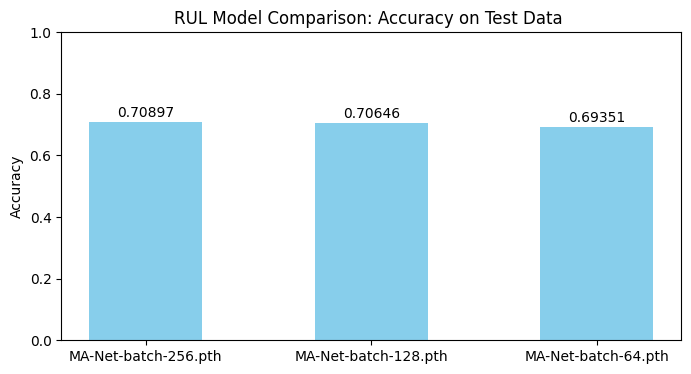

In [16]:
# 1. Plot model accuracies for comparison
plt.figure(figsize=(8, 4))
plt.bar(model_names, accuracies, color='skyblue',  width=0.5)
plt.ylim(0, 1)

for i, (model_name, accuracy) in enumerate(zip(model_names, accuracies)):
  x_pos = i  # Adjust x position if needed (e.g., for center alignment)
  y_pos = accuracy + 0.005  # Adjust y position for some space above the bar

  plt.text(x_pos, y_pos, f"{accuracy:.5f}", ha='center', va='bottom')  # Format and align the label

  plt.ylabel('Accuracy')
  plt.title('RUL Model Comparison: Accuracy on Test Data ')

plt.savefig(f'RUL Model Comparison: Accuracy on Test Data')
plt.show()

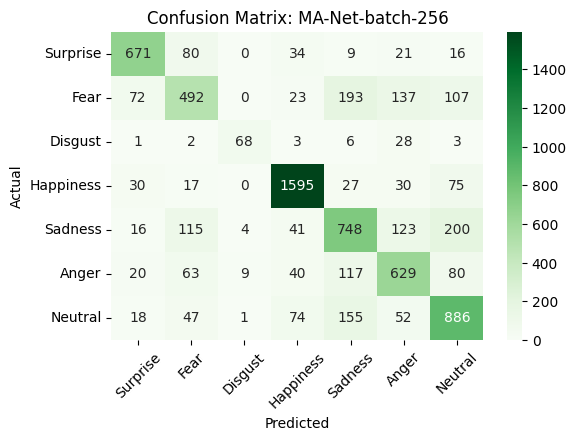

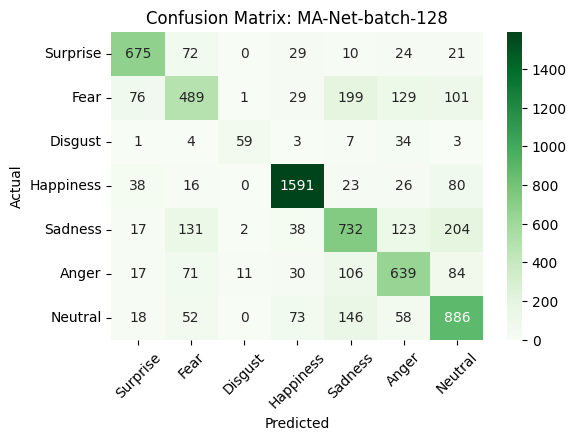

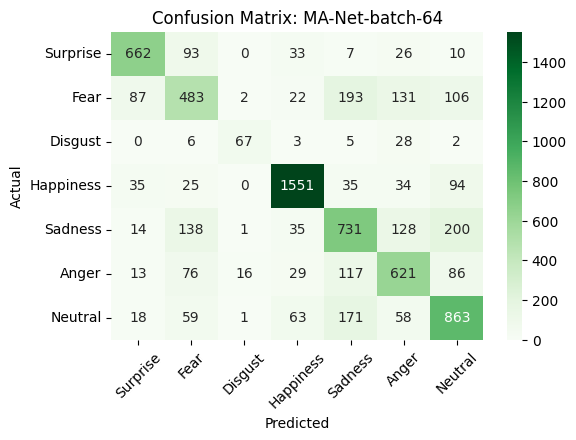

In [17]:
# 2. Plot Confusion Matrices
labels = ['Surprise' ,'Fear', 'Disgust', 'Happiness', 'Sadness', 'Anger', 'Neutral']
for i, conf_mat in enumerate(conf_mats):
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
    txt = model_names[i].split(".")
    plt.title(f'Confusion Matrix: {txt[0]}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.xticks(rotation=45)
    plt.savefig(f'Confusion Matrix fernorm: {txt[0]}')
    plt.show()

In [19]:
print("MA-Net model class reports")
# 3. Print Classification Reports for each model
for i, class_report in enumerate(class_reports):

    class_report_df = pd.DataFrame(class_report).transpose()
    new_labels = labels
    class_report_df.index = new_labels + ['accuracy', 'macro avg', 'weighted avg']
    print("")
    print("")
    print("----------------------------------------------------")
    txt = model_names[i].split(".")
    print(f'Classification Report: {txt[0]}')
    print(class_report_df)

MA-Net model class reports


----------------------------------------------------
Classification Report: MA-Net-batch-256
              precision    recall  f1-score      support
Surprise       0.810386  0.807461  0.808921   831.000000
Fear           0.602941  0.480469  0.534783  1024.000000
Disgust        0.829268  0.612613  0.704663   111.000000
Happiness      0.881215  0.899098  0.890067  1774.000000
Sadness        0.596016  0.599840  0.597922  1247.000000
Anger          0.616667  0.656576  0.635996   958.000000
Neutral        0.648135  0.718573  0.681538  1233.000000
accuracy       0.708972  0.708972  0.708972     0.708972
macro avg      0.712090  0.682090  0.693413  7178.000000
weighted avg   0.707623  0.708972  0.706639  7178.000000


----------------------------------------------------
Classification Report: MA-Net-batch-128
              precision    recall  f1-score      support
Surprise       0.801663  0.812274  0.806934   831.000000
Fear           0.585629  0.477539  0.52608

In [ ]:
!mkdir /content/FER-NN-MA-Net/checkpoint/models

In [ ]:
!gdown 1tro_RCovLKNACt4MKYp3dmIvvxiOC2pi -O /content/FER-NN-MA-Net/checkpoint/models/Pretrained_on_MSCeleb.pth.tar

Downloading...
From (original): https://drive.google.com/uc?id=1tro_RCovLKNACt4MKYp3dmIvvxiOC2pi
From (redirected): https://drive.google.com/uc?id=1tro_RCovLKNACt4MKYp3dmIvvxiOC2pi&confirm=t&uuid=a02507f0-841e-434b-9949-8df54a456e79
To: /content/FER-NN-MA-Net/checkpoint/models/Pretrained_on_MSCeleb.pth.tar
100% 509M/509M [00:09<00:00, 55.5MB/s]
